In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bidict import bidict
from collections import defaultdict
from datetime import datetime

%matplotlib inline

# Dynamic Programming

## Q1

Implement the discrete MDP model.

In [2]:
class MDP:
    """This class implements a Markov Decision Process.
    
    It saves all the information for the states, the actions and the rewards.
    
    Attributes:
        num_states (int)   : the total number of the states
        name_states(bidict): the bi-directional dict for the pairs 
                             [name(str), index(int)]. eg: ("s0" -> 1 && 1 -> "s0")
        set_states (list)  : the list of State instances, the order is consistant 
                             with the one of the indices in name_states
    """
    
    def __init__(self, set_states, set_acts, set_rewards):
        """Init MDP with given parameters. 
        
        After the initialization, the class can be used directly for the simulation.
        
        Args:
            set_states(list(str))  : the names of all states, eg. ["a0", "a1", ...]
            set_acts  (list(list)) : each sub-list contains the info for one action, namely 
                                     [name_start_state(str), name_end_state(str), name_action(str), proba(float)],
                                     eg. ["s0", "s0", "a0", 0.55]
            set_rewards(list(list)): each sub-list contains the info for one reward, namely
                                     [name_start_state(str), name_action(str), reward(float)],
                                     eg. ["s0", "a0", 1.]
        """
        
        self.num_states = len(set_states)
        self.name_states = bidict(zip(set_states, range(self.num_states)))
        self.set_states = [State(i, set_states[i], self.num_states) for i in range(self.num_states)]

        self.set_acts_matrix(set_acts)
        self.set_rewards_matrix(set_rewards)
        
    def set_rewards_matrix(self, set_rewards):
        """Save reward information in each State instance.
        
        Args:
            set_rewards(list(list)): Descriptions given in the __init__ func.
        """
        
        # reward = (state, action, reward)
        for reward in set_rewards:
            self.set_states[self.name_states[reward[0]]].set_reward_dict(reward[1], reward[2])
            
    def set_acts_matrix(self, set_acts):
        """Save action information in each State instance.
        
        Args:
            set_acts(list(list)): Descriptions given in the __init__ func.
        """
        
        # act = (state_in, state_out, action, proba)
        for act in set_acts:
            self.set_states[self.name_states[act[0]]].add_action(act[2], self.name_states[act[1]], act[3])
            
        for i in range(self.num_states):
            self.set_states[i].set_action_matrix()

In [3]:
class State:
    """The class simulates one state of an MDP. 
    
    It keeps the informations of a state: the name, the index, the actions, the rewards and so on.
    
    Attributes:
        idx       (int)       : the index of this state in the MDP
        name      (str)       : the name of this state
        num_states(int)       : the total number of states in the MDP
        set_acts  (set(str))  : the set contains the names of all actions
        list_acts (list(list)): each sub-list contains the info for one action, namely
                                [name_action(str), idx_end_state(int), proba(float)]
        num_acts  (int)       : the total number of actions in this state
        idx_acts  (bidict)    : the bi-directional dict for the pairs 
                                [name(str), index(int)]. eg: ("a0" -> 1 && 1 -> "a0")
        mat_acts  (np.array)  : a matrix of size (num_actions, num_states), which saves the 
                                transition probability for each action
        rewards   (np.array)  : a matrix of size (num_actions,), each entry saves the reward
                                we obtain when we choose this action
    """
    
    def __init__(self, idx, name, num_states):
        """Init a state of an MDP with given parameters. 
        
        The instance is initialized by an MDP instance. Then it can be used directly.
        
        Args:
            idx        (int): the index of the state in the MDP
            name       (str): the name of the state
            num_states (int): the total number of states in the MDP
        """
        self.idx = idx
        self.name = name
        self.num_states = num_states
        
        self.set_acts = set()
        self.list_acts = []
        
    def add_action(self, action, state_out, proba):
        """Add one action for the state
        
        Args:
            action    (str)  : the name of the action
            state_out (int)  : the index of the end state
            proba     (float): the probability of transition when we take a certain action 
                               and get into a certain state.
        
        """
        self.set_acts.add(action)
        self.list_acts.append([action, state_out, proba])
        
    
    def set_action_matrix(self):
        """Set the action matrix for the state
        
        After calling this function, the action matrix is well defined.
        """        
        self.num_acts = len(self.set_acts)
        self.rewards = np.zeros((self.num_acts))
        self.idx_acts = bidict(zip(self.set_acts, range(self.num_acts)))
        self.mat_acts = np.zeros((self.num_acts, self.num_states))
        
        # act = (action_name, state_out_idx, proba, reward)
        for act in self.list_acts:
            self.mat_acts[self.idx_acts[act[0]], act[1]] = act[2]
            
    def set_reward_dict(self, action, reward):
        """Set the reward for one  action
        
        Args:
            action (str)  : the name of the action 
            reward (float): the reward for the action
        """
        self.rewards[self.idx_acts[action]] = reward

In [4]:
states = ["s0", "s1", "s2"]

actions = [ ["s0", "s0", "a0", 0.55],
            ["s0", "s1", "a0", 0.45],
            ["s0", "s0", "a1", 0.3],
            ["s0", "s1", "a1", 0.7],
            ["s0", "s0", "a2", 1.0],
            ["s1", "s0", "a0", 1.0],
            ["s1", "s1", "a1", 0.4],
            ["s1", "s2", "a1", 0.6],
            ["s1", "s1", "a2", 1.0],
            ["s2", "s1", "a0", 1.0],
            ["s2", "s2", "a1", 0.4],
            ["s2", "s1", "a1", 0.6],
            ["s2", "s2", "a2", 1.0]]

rewards = [ ["s0", "a0", 0],
            ["s0", "a1", 0],
            ["s0", "a2", 0.05],
            ["s1", "a0", 0],
            ["s1", "a1", 0],
            ["s1", "a2", 0],
            ["s2", "a0", 0],
            ["s2", "a1", 1],
            ["s2", "a2", 0.9]]

gamma = 0.95

In [5]:
my_mdp = MDP(states, actions, rewards)

## Q2

Implement the value iteration in order to identify a 0.1-optimal policy.

In [56]:
def value_iteration(mdp, gamma = 0.95, K = 1000, epsilon = 0.01):
    """This function implements the value iteration method for an MDP
    
    It aims to find the optimal policy for a given MDP by optimizing the matrix V iteratively.
    
    Args:
        mdp     (MDP)  : the markov decision process
        gamma   (float): the discount factor
        K       (int)  : the maximum number of iterations
        epsilon (float): the acceptable inifinity norm difference, it decides when we stop the iteration
        
    Returns:
        V_history (list(np.array)): a list which contains the V for each iteration,
                                    the last V is the optimal V.
    """
    
    V_history = [np.zeros((mdp.num_states))]
    
    for k in range(K):
        V1 = np.zeros_like(V_history[-1])
        # Bellman equation for state i
        for i in range(mdp.num_states):
            # Max value for action j
            curr_acts = [my_mdp.set_states[i].rewards[j] + gamma * (V_history[-1] * my_mdp.set_states[i].mat_acts[j]).sum()
                         for j in range(mdp.set_states[i].num_acts)]
            V1[i] = max(curr_acts)
            
        if np.max(np.abs(V_history[-1] - V1)) < epsilon:
            break
        else:
            V_history.append(V1)
            
    return V_history

In [7]:
def greedy_policy(mdp, V_opt, gamma = 0.95):
    """This function find the greedy policy according to a value matrix
    
    It simply takes the action which maximizes the reward for each state.
    
    Args:
        mdp     (MDP)     : the markov decision process
        V_opt   (np.array): the optimal value matrix
        gamma   (float)   : the discount factor
        
    Returns:
        P_opt (list(str)): each entry represents the name of the chosen action at the corresponding state
    """
    
    P_opt = [None] * mdp.num_states
    
    for i in range(mdp.num_states):
        curr_acts = [my_mdp.set_states[i].rewards[j] + gamma * (V_opt * my_mdp.set_states[i].mat_acts[j]).sum()
                         for j in range(mdp.set_states[i].num_acts)]
        curr_opt = curr_acts.index(max(curr_acts))
        P_opt[i] = my_mdp.set_states[i].idx_acts.inv[curr_opt]
        
    return P_opt

Implement policy evaluation to compute $v^\star$.

In [8]:
def policy_evaluation(mdp, policy, gamma = 0.95):
    """This function implements the policy evaluation method for an MDP
    
    It calculates the corresponding value matrix given a policy.
    
    Args:
        mdp      (MDP)      : the markov decision process
        policy   (list(str)): the chosen policy, each entry indicates the chosen action for the corresponding state
        gamma    (float)    : the maximum number of iterations
        
    Returns:
        value (np.array): the value matrix of size (num_states,)
    """
    
    mat_policy = np.zeros((mdp.num_states, mdp.num_states))
    mat_reward = np.zeros((mdp.num_states, 1))
    
    for i in range(mdp.num_states):
        idx_act = my_mdp.set_states[i].idx_acts[policy[i]]
        mat_policy[i] = my_mdp.set_states[i].mat_acts[idx_act]
        mat_reward[i, 0] = my_mdp.set_states[i].rewards[idx_act]
        
    value = np.dot(np.linalg.inv(np.eye(mdp.num_states) - gamma * mat_policy), mat_reward)
    
    return value.reshape((-1))

Plot $\|v^k - v^\star\|_\infty$ as a function of iteration $k$.

In [9]:
def plot_loss(V_loss):
    
    plt.figure()
    plt.plot(range(len(V_loss)), V_loss)
    plt.xlabel("Iter")
    plt.ylabel("|v_k - v^*|_{inf}")
    plt.title("Inf Norm of (v-v*) w.r.t. Number of Iteration")
    plt.grid()
    plt.show()

Run all the functions and show the results.

In [59]:
start = datetime.now()
# estimate VI time
V_history = value_iteration(my_mdp, gamma)
# show VI tiome
stop = datetime.now()
print('VI uses %fs' % (stop - start).total_seconds())

P_opt = greedy_policy(my_mdp, V_history[-1], gamma)

VI uses 0.007932s


In [11]:
print("The optimal policy")
print("-" * 18)
for i in range(my_mdp.num_states):
    print("    ", my_mdp.name_states.inv[i], ": ", P_opt[i])

The optimal policy
------------------
     s0 :  a1
     s1 :  a1
     s2 :  a2


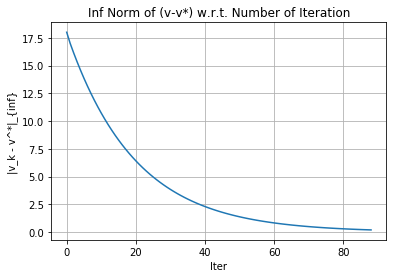

In [12]:
V_star = policy_evaluation(my_mdp, P_opt, gamma)
plot_loss([np.max(np.abs(V_star - V)) for V in V_history])

## Q3

Implement the exact policy iteration.

In [13]:
def policy_iteration(mdp, p_init, gamma = 0.95, K = 1000):
    """This function implements the policy iteration method for an MDP
    
    It aims to find the optimal policy for a given MDP by optimizing the policy P iteratively.
    We stop the iteration when the policy does not change.
    
    Args:
        mdp     (MDP)      : the markov decision process
        p_init  (list(str)): the initial policy
        gamma   (float)    : the discount factor
        K       (int)      : the maximum number of iterations
        
    Returns:
        p0 (list(str)): the final optimal policy
        k  (int)      : the iteration where the algorithm converges
    """
    
    p0 = p_init
    
    for k in range(K):
        v0 = policy_evaluation(mdp, p0, gamma)
        p1 = greedy_policy(mdp, v0, gamma)
        
        if p1 == p0:
            return p0, k
        else:
            p0 = p1
            
    return p0, K

In [14]:
start = datetime.now()
# estimate VI time
P_opt_pi, K_pi = policy_iteration(my_mdp, ["a0", "a0", "a0"], gamma)
# show VI tiome
stop = datetime.now()
print('PI uses %fs' % (stop - start).total_seconds())
print("PI converges at iteration %d." % K_pi)

PI uses 0.001115s
PI converges at iteration 4.


# Exercise 2

In [15]:
from gridworld import GridWorld1
import gridrender as gui
import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
my_env = GridWorld1

In [17]:
print("State to Coord: ", my_env.state2coord)
print("Coord to State: ", my_env.coord2state)
print("State Actions : ", my_env.state_actions)

for i, el in enumerate(my_env.state_actions):
        print("\t\t s{}: {}".format(i, my_env.action_names[el]))

State to Coord:  [[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3]]
Coord to State:  [[ 0  1  2  3]
 [ 4 -1  5  6]
 [ 7  8  9 10]]
State Actions :  [[0, 1], [0, 2], [0, 1, 2], [0], [1, 3], [0, 1, 3], [0], [0, 3], [0, 2], [0, 2, 3], [2, 3]]
		 s0: ['right' 'down']
		 s1: ['right' 'left']
		 s2: ['right' 'down' 'left']
		 s3: ['right']
		 s4: ['down' 'up']
		 s5: ['right' 'down' 'up']
		 s6: ['right']
		 s7: ['right' 'up']
		 s8: ['right' 'left']
		 s9: ['right' 'left' 'up']
		 s10: ['left' 'up']


## Q4

Implement value function estimation using Monte-Carlo. 

In [18]:
def mc_value_estimation(env, policy, gamma = 0.95, K = 1000, T_max = 20):
    """This function estimates the value matrix given a chosen policy.
    
    It simulates the process for many times and estimates the matrix by Monte-Carlo method.
    
    Args:
        env    (GridWorld): an instance of GridWorld, which describes the whole environment
        policy (list(int)): the chosen policy, each entry indicates the action in the corresponding state
        gamma  (float)    : the discount factor
        K      (int)      : the total number of episoids
        T_max  (int)      : the maximum time we move in each episoid
        
    Returns:
        v_history (list(np.array)): a list which contains the V for each iteration,
                                    the last V is the optimal V.
        n_mc      (np.array)      : the visit probability for each state during the simulation.
    """
    
    v_history = []
    v_mc = np.zeros((env.n_states))
    n_mc = np.zeros((env.n_states))
        
    for k in range(K):
        s0 = env.reset()
        state = s0
        t = 0
        coord = env.state2coord[state]
        while type(env.grid[coord[0]][coord[1]]) != int and t < T_max:
            action = policy[state]
            state = env.step(state, action)[0]
            coord = env.state2coord[state]
            t += 1
        if type(env.grid[coord[0]][coord[1]]) == int:
            # If the initial state is s3 or s6, we restart a new simulation
            v_mc[s0] += pow(gamma, t - 1) * env.grid[coord[0]][coord[1]] if t > 0 else 0
            n_mc[s0] += 1
            # avoid divided by 0
            v_history.append(v_mc / (n_mc + 1e-8))

    n_mc = n_mc / float(K)
    
    return v_history, n_mc

Plot $J_n - J^\pi$ as a function of the number of the iteration $n$.

In [19]:
def plot_estimator(J_diff):
    
    plt.figure()
    plt.plot(J_diff)
    plt.xlabel("Iter")
    plt.ylabel("J_n - J_pi")
    plt.title("J_n - J_pi w.r.t. the number of the iteration")
    plt.grid()
    plt.show()

In [63]:
my_env.compute_available_actions()
# Set policy
policy = [0 if (0 in my_env.state_actions[i]) else 3 for i in range(my_env.n_states)]
# Value estimation
v_history, n_mc = mc_value_estimation(my_env, policy, K = 1000)
# Given value
v_q4 = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514])

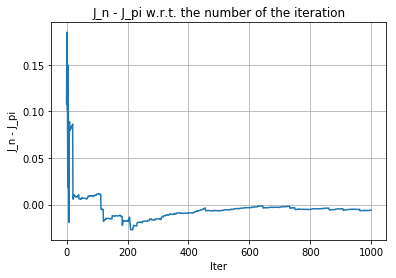

In [21]:
J_pi = np.sum(n_mc * v_q4)
plot_estimator([np.sum(n_mc * v) - J_pi for v in v_history])

## Q5

Implement Q-learning algorithm for a grid in order to find an optimal policy.

In [22]:
def q_learning(env, actions, v_opt = None, epsilon = 0.1, gamma = 0.95, K = 1000, T_max = 20, a = 1.):
    """This function implements the q-learning algorithm to find an optimal policy.
    
    Args:
        env     (GridWorld)      : an instance of GridWorld, which describes the whole environment
        actions (list(list(int))): each sub-list contains the possible actions for the corresponding state
        v_opt   (np.array)       : a matrix of size (n_state,), which is used to evaluate the convergence speed.
                                   If it is None (default), this metric will not be tracked.
        epsilon (float)          : the probability for choosing actions randomly
        gamma   (float)          : the discount factor
        K       (int)            : the total number of episoids
        T_max   (int)            : the maximum time we move in each episoid
        a       (float)          : the learning rate
    
    Returns:
        mat_q          (np.array)   : a matrix of size (n_states, n_actions)
        reward_history (list(float)): the accumulated rewards for each episoid
        loss_history   (list(float)): the infinity norm of the difference between the optimal V 
                                      and the V we learnt in each episoid.
                                      If the optimal is not provided, loss_history is None.
    """
    
    mat_q = np.zeros((env.n_states, len(env.action_names)))
    mat_n = np.zeros((env.n_states, len(env.action_names)))
    reward_history = [0]
    loss_history = None if type(v_opt) == type(None) else []
    
    for k in range(K):
        t = 0
        accum_reward = reward_history[-1]
        # choose the initial state randomly
        s1 = env.reset()
        coord = env.state2coord[s1]
        # iteration for each episoid
        while type(env.grid[coord[0]][coord[1]]) != int and t < T_max:
            s0 = s1
            # choose action by the defined strategy
            if np.random.rand() < 1 - epsilon:
                action = actions[s0][np.argmax(mat_q[s0, actions[s0]])]
            else:
                action = np.random.choice(actions[s0])
            # move to the new state
            s1, reward, absorb = env.step(s0, action)
            # record the result
            mat_n[s0, action] += 1
            accum_reward += reward
            delta = reward + gamma * mat_q[s1].max() - mat_q[s0, action]
            mat_q[s0, action] += a / mat_n[s0, action] * delta
            # stop condition
            if absorb:
                break
            else:
                coord = env.state2coord[s1]
                t += 1
        # record infinity norm        
        if type(v_opt) != type(None):        
            loss_history.append(np.max(np.abs(v_opt - mat_q.max(1))))
        # record accumulated reward
        reward_history.append(accum_reward)
    
    return mat_q, reward_history, loss_history

In [23]:
def plot_qlearning(reward_history, loss_history, x_data = None, xlabel = "Iter", x_title = "Number of iteration"):
    """The plot function for the two metrics for q-learning algorithm.
    
    Args:
        reward_history (list(float))           : the accumulated reward for each x
        loss_history   (list(float))           : the infinity norm for each x
        x_data         (np.array / list(float)): the data for x axis. If it is None, the x data is
                                                 [0, 1, ..., len(reward_history)]
        xlabel         (str)                   : the name for x axis
        x_title        (str)                   : the name for completing the figure title
    """ 
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(reward_history) if type(x_data) == type(None) else plt.plot(x_data, reward_history)
    plt.xlabel(xlabel)
    plt.ylabel("Accumulated Reward")
    plt.title("Accumulated Reward w.r.t. " + x_title)
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss_history) if type(x_data) == type(None) else plt.plot(x_data, loss_history)
    plt.xlabel(xlabel)
    plt.ylabel("|v^* - v^pi|_{inf}")
    plt.title("Infinity norm w.r.t. " + x_title)
    plt.grid()
    
    plt.show()

In [24]:
v_opt = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001])

Observe the influence of $\epsilon$

In [53]:
lepsilon = np.arange(0.01, 0.9, 0.05)
lreward, lloss = [], []

for epsilon in lepsilon:
    my_matq, reward_history, loss_history = q_learning(my_env, my_env.state_actions, v_opt = v_opt, K = 10000, epsilon = epsilon)
    lreward.append(reward_history[-1])
    lloss.append(loss_history[-1])

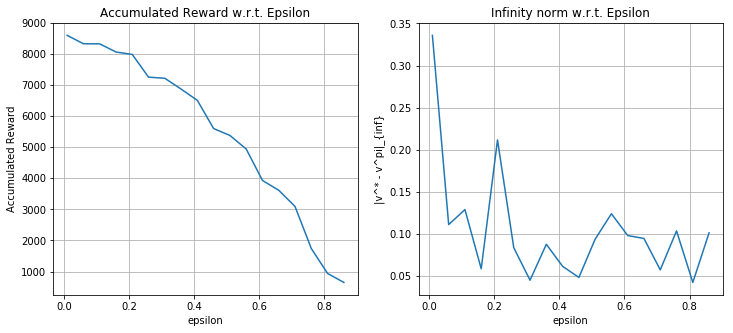

In [54]:
plot_qlearning(lreward, lloss, lepsilon, "epsilon", "Epsilon")

In [55]:
print("The highest accumulated reward : epsilon equals to %f" % lepsilon[lreward.index(max(lreward))])
print("The lowest infinity norm       : epsilon equals to %f" % lepsilon[lloss.index(min(lloss))])

The highest accumulated reward : epsilon equals to 0.010000
The lowest infinity norm       : epsilon equals to 0.810000


Observe the influence of the learning rate strategy.

In [46]:
la = np.arange(0.5, 5, 0.5)
lreward, lloss = [], []

for a in la:
    my_matq, reward_history, loss_history = q_learning(my_env, my_env.state_actions, v_opt = v_opt, K = 10000, epsilon = 0.1, a = a)
    lreward.append(reward_history[-1])
    lloss.append(loss_history[-1])

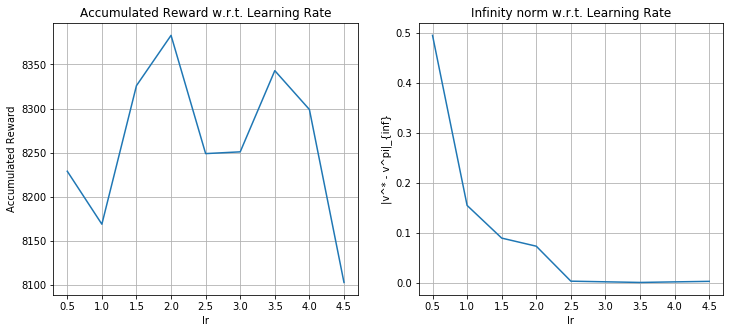

In [47]:
plot_qlearning(lreward, lloss, la, "lr", "Learning Rate")

In [48]:
print("The highest accumulated reward : epsilon equals to %f" % la[lreward.index(max(lreward))])
print("The lowest infinity norm       : epsilon equals to %f" % la[lloss.index(min(lloss))])

The highest accumulated reward : epsilon equals to 2.000000
The lowest infinity norm       : epsilon equals to 3.500000


For the final model, we choose the parameters as below:

* $\epsilon = 0.1$
* Learning rate $\alpha_i (x_t, a_t) = \cfrac{2.}{\mbox{The time we visited the pair}}$
* $K = 100000$

And we visualize the speed of the convergence.

In [66]:
my_matq, reward_history, loss_history = q_learning(my_env, my_env.state_actions, v_opt = v_opt, K = 100000, epsilon = 0.1, a = 2)

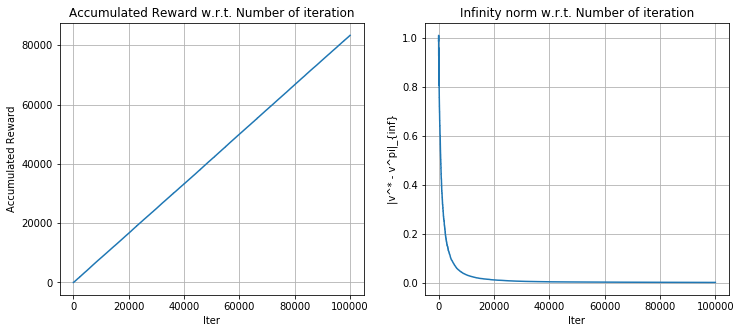

In [67]:
plot_qlearning(reward_history, loss_history)

In [68]:
gui.render_q(my_env, my_matq)